In [15]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from ptflops import get_model_complexity_info

In [28]:
conf_list = ["AAAI", "CVPR", "ICML", "KDD", "NeurIPS"]
conf_map = {name: i for i, name in enumerate(conf_list)}
root_dir = "CCFA TXT"
batch_size = 8
num_epochs = 100

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

使用设备: cuda


In [30]:
entity_df = pd.read_csv("entity_embeddings.csv", index_col=0)
entity_emb_dict = entity_df.to_dict(orient="index")
kg_dim = len(next(iter(entity_emb_dict.values())))

In [31]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [32]:
for param in bert_model.parameters():
    param.requires_grad = False

In [33]:
# 解冻 encoder.layer.8 ~ encoder.layer.11 和 pooler
for name, param in bert_model.named_parameters():
    if any(n in name for n in ["encoder.layer.8", "encoder.layer.9", "encoder.layer.10", "encoder.layer.11", "pooler"]):
        param.requires_grad = True

In [34]:
class PaperDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.text_features = []
        self.labels = []

        for conf in conf_list:
            if conf == "NeurIPS":
                txt_paths = glob.glob(os.path.join(root_dir, "NeurIPS2023", "txt", "*.txt"))
                txt_paths += glob.glob(os.path.join(root_dir, "NeurIPS2024", "txt", "*.txt"))
            else:
                txt_paths = glob.glob(os.path.join(root_dir, conf, "txt", "*.txt"))

            print(f"[{conf}] 读取文件数: {len(txt_paths)}")

            for path in txt_paths:
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                paper_id = os.path.basename(path).replace(".txt", "")
                label = conf_map[conf]

                tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to(device)
                with torch.no_grad():
                    text_emb = bert_model(**tokens).pooler_output.squeeze(0).cpu()

                self.samples.append(paper_id)
                self.text_features.append(text_emb)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paper_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        text_emb = self.text_features[idx].to(device)

        if paper_id in entity_emb_dict:
            kg_vector = list(entity_emb_dict[paper_id].values())
            kg_emb = torch.tensor(kg_vector, dtype=torch.float)
        else:
            kg_emb = torch.zeros(kg_dim, dtype=torch.float)

        kg_emb = kg_emb.to(device)
        return torch.cat([text_emb, kg_emb]), label

In [35]:
class PaperClassifier(nn.Module):
    def __init__(self, kg_dim, num_classes):
        # super().__init__()
        # self.net = nn.Sequential(
        #     nn.Linear(768 + kg_dim, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, num_classes)
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 + kg_dim, 512),
            nn.LayerNorm(512),  # 添加归一化层
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [36]:
dataset = PaperDataset(root_dir)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ====== 初始化模型 ======
model = PaperClassifier(kg_dim=kg_dim, num_classes=len(conf_list)).to(device)
criterion = nn.CrossEntropyLoss()
bert_params = list(filter(lambda p: p.requires_grad, bert_model.parameters()))
optimizer = torch.optim.Adam(
    list(model.parameters()) + bert_params,
    lr=1e-5  # 微调 BERT 建议更小的学习率
)

[AAAI] 读取文件数: 200
[CVPR] 读取文件数: 199
[ICML] 读取文件数: 200
[KDD] 读取文件数: 17
[NeurIPS] 读取文件数: 0


In [37]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
    train_losses.append(total_loss)
    train_accs.append(correct / len(train_dataset))

    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += criterion(logits, y).item()
            val_correct += (logits.argmax(1) == y).sum().item()
    val_losses.append(val_loss)
    val_accs.append(val_correct / len(val_dataset))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")


Epoch 1/100 | Train Loss: 92.2090 | Val Loss: 19.8666 | Train Acc: 0.2961 | Val Acc: 0.3821
Epoch 2/100 | Train Loss: 79.8843 | Val Loss: 19.0288 | Train Acc: 0.3550 | Val Acc: 0.3902
Epoch 3/100 | Train Loss: 77.1775 | Val Loss: 18.6451 | Train Acc: 0.3448 | Val Acc: 0.3902
Epoch 4/100 | Train Loss: 76.3447 | Val Loss: 18.3761 | Train Acc: 0.3367 | Val Acc: 0.4390
Epoch 5/100 | Train Loss: 75.5090 | Val Loss: 18.1158 | Train Acc: 0.3590 | Val Acc: 0.4634
Epoch 6/100 | Train Loss: 73.6671 | Val Loss: 18.0672 | Train Acc: 0.3996 | Val Acc: 0.4146
Epoch 7/100 | Train Loss: 74.2282 | Val Loss: 17.8755 | Train Acc: 0.3753 | Val Acc: 0.4878
Epoch 8/100 | Train Loss: 73.3857 | Val Loss: 17.7200 | Train Acc: 0.4219 | Val Acc: 0.5041
Epoch 9/100 | Train Loss: 72.7310 | Val Loss: 17.6459 | Train Acc: 0.4341 | Val Acc: 0.4959
Epoch 10/100 | Train Loss: 73.3470 | Val Loss: 17.3694 | Train Acc: 0.4057 | Val Acc: 0.5285
Epoch 11/100 | Train Loss: 70.8545 | Val Loss: 17.3204 | Train Acc: 0.4665 | Va

In [38]:
from sklearn.preprocessing import label_binarize

full_loader = DataLoader(dataset, batch_size=batch_size)

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in full_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

preds = np.argmax(all_probs, axis=1)
accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds, average='macro')
recall = recall_score(all_labels, preds, average='macro')
f1 = f1_score(all_labels, preds, average='macro')

print("\n=== 验证集评估结果 ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

input_size = (768 + kg_dim, )
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(
        model,
        input_res=input_size,
        as_strings=True,
        print_per_layer_stat=True,
        verbose=True
    )

print(f"\n模型分类器部分的 FLOPs: {macs}")
print(f"模型分类器参数量: {params}")


=== 验证集评估结果 ===
Accuracy:  0.8458
Precision: 0.8829
Recall:    0.8540
F1 Score:  0.8660
PaperClassifier(
  553.48 k, 100.000% Params, 553.48 KMac, 99.861% MACs, 
  (net): Sequential(
    553.48 k, 100.000% Params, 553.48 KMac, 99.861% MACs, 
    (0): Linear(419.33 k, 75.762% Params, 419.33 KMac, 75.658% MACs, in_features=818, out_features=512, bias=True)
    (1): LayerNorm(1.02 k, 0.185% Params, 512.0 Mac, 0.092% MACs, (512,), eps=1e-05, elementwise_affine=True)
    (2): ReLU(0, 0.000% Params, 512.0 Mac, 0.092% MACs, )
    (3): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.3, inplace=False)
    (4): Linear(131.33 k, 23.728% Params, 131.33 KMac, 23.695% MACs, in_features=512, out_features=256, bias=True)
    (5): LayerNorm(512, 0.093% Params, 256.0 Mac, 0.046% MACs, (256,), eps=1e-05, elementwise_affine=True)
    (6): ReLU(0, 0.000% Params, 256.0 Mac, 0.046% MACs, )
    (7): Linear(1.28 k, 0.232% Params, 1.28 KMac, 0.232% MACs, in_features=256, out_features=5, bias=True)
  )
)

模

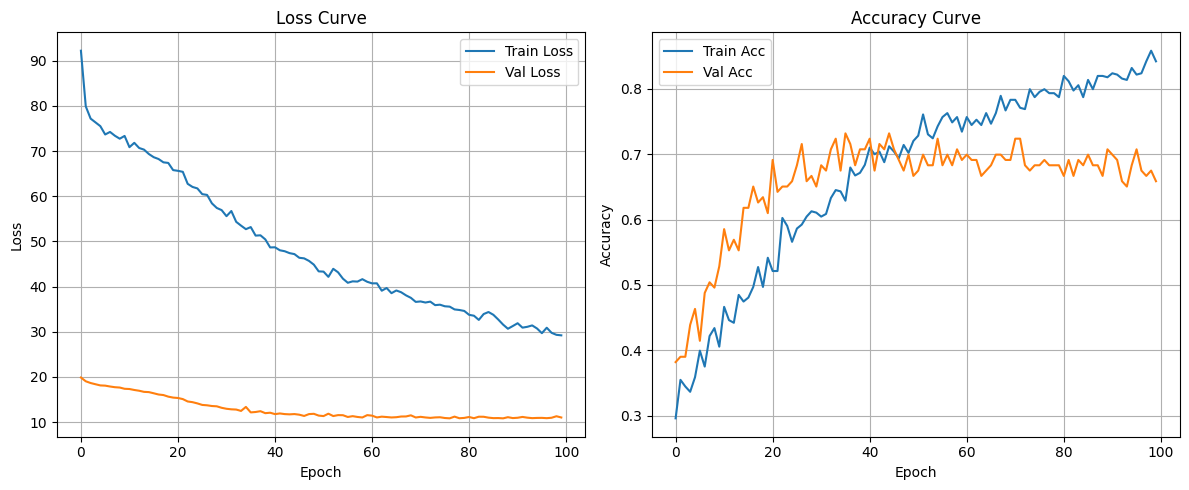

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("2_training_testing_curves.png")
plt.show()